# DATA612
### PROJECT 3:Matrix Factorization methods
### Ananya 

# Introduction


### svd gives us best lower rank decomposition.
### A = U . Sigma . V^T

#### u = user to concept  similarity matrix (orthogonal matrix)
#### sigma = diagonal matrix  ( stength of concept) 
#### v = movie to concep matrix (orthogonal matrix)
#### A = original  input  matrix 

SVD is a matrix factorization technique that is usually used to reduce the number of features of a data set by reducing space dimensions from N to K where K < N. As in real wordld we can see a lot of noise.

By tacking kth dimenssion we will build 3 factor U,sigma and V and the outcome matrix B will be closely similar to original matrix. Idealy  we will find best fit for k  where rank(B) = K

In this project we will try for diffrent K values and take the best k when we see RMSE is mimum. 

It is mostly used with collbarative filtering Model. Because it does not need exta information and will contains user to item rating matrix.


### How SVD is useful in recomndation system 

By applying matrix factorization for recommender systems we can get hidden correlation between diffrent user, which is some how ignored in colabarative filtering approach such as items frequently bought or viewed.
Using this capability we can estimate if a user is going to like a movie that they never saw. And if that estimated rating is high, we can recommend that movie to the user. we have devloped a model using this technique below.



In [1]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import diag
from numpy import dot
from scipy.linalg import svd
from math import sqrt
import numpy as geek 
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse.linalg import svds
from surprise import SVD, accuracy
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
import matplotlib.pyplot as plt

###  Loading data

In [2]:
data = pd.read_csv(r'ratings.csv')
data.head()

,userId,movieId,rating,timestamp
0,12882,1,4.0,1147195252
1,12882,32,3.5,1147195307
2,12882,47,5.0,1147195343
3,12882,50,5.0,1147185499
4,12882,110,4.5,1147195239


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264505 entries, 0 to 264504
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     264505 non-null  int64  
 1   movieId    264505 non-null  int64  
 2   rating     264505 non-null  float64
 3   timestamp  264505 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 8.1 MB


In [4]:
data.rating.value_counts()

4.0    66481
3.5    47305
3.0    44574
4.5    30529
5.0    25767
2.5    19017
2.0    15978
1.5     5716
1.0     5543
0.5     3595
Name: rating, dtype: int64

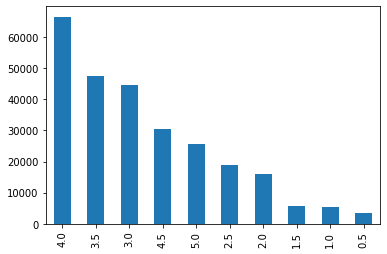

In [5]:
data.rating.value_counts().plot(kind='bar')
plt.show()

In [6]:
data_movie= pd.read_csv(r"movies.csv", encoding = 'unicode_escape')
data_movie

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
2495,109487,Interstellar (2014),Sci-Fi|IMAX
2496,111362,X-Men: Days of Future Past (2014),Action|Adventure|Sci-Fi
2497,111759,Edge of Tomorrow (2014),Action|Sci-Fi|IMAX
2498,112556,Gone Girl (2014),Drama|Thriller


In [7]:
# before calculating svd we are filing all unknown  valuses with 0 
rating_data = data.pivot(index = 'userId', columns ='movieId', values = 'rating').fillna(0)
rating_data.head()

movieId,1,2,3,4,5,6,7,9,10,11,...,106487,106489,106782,106920,109374,109487,111362,111759,112556,112852
userId,,,,,,,,,,,,,,,,,,,,,
316,2.5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,2.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
359,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
370,4.5,4.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,2.5,3.0,4.5,4.0,0.0,0.0,3.0,4.5,3.5,3.0
910,5.0,4.0,3.5,0.0,3.5,3.5,0.0,0.0,0.0,4.0,...,0.0,0.0,3.5,0.0,0.0,0.0,0.0,4.5,0.0,0.0


In [8]:
rating_data_np = rating_data.values
rating_data_np.shape

(862, 2500)

In [9]:
# row level mean 
user_ratings_mean = np.mean(rating_data_np, axis = 1)
user_ratings_mean.shape

(862,)

### normalizing the data by substacting from mean

In [10]:
rating_balance = rating_data_np - user_ratings_mean.reshape(-1, 1)
rating_balance

array([[ 2.3282, -0.1718, -0.1718, ..., -0.1718, -0.1718, -0.1718],
       [-0.0918, -0.0918, -0.0918, ..., -0.0918, -0.0918, -0.0918],
       [ 3.772 , -1.228 , -1.228 , ..., -1.228 , -1.228 , -1.228 ],
       ...,
       [ 2.2818,  0.2818,  0.2818, ..., -0.7182, -0.7182, -0.7182],
       [-0.023 , -0.023 , -0.023 , ..., -0.023 , -0.023 , -0.023 ],
       [ 2.4278, -0.5722, -0.5722, ..., -0.5722, -0.5722, -0.5722]])

In [11]:
# choosing k = 50 
U, sigma, Vt = svds(rating_balance, k = 50)

In [12]:
U.size


43100

In [13]:
sigma = diag(sigma)


In [14]:
sigma.size

2500

In [15]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.reshape(-1, 1)
all_user_predicted_ratings

array([[ 2.11906711,  0.61385236, -0.05222982, ...,  0.39116413,
         0.16155901,  0.23388866],
       [ 0.95573809, -0.23727701, -0.10567897, ...,  0.12229678,
         0.04380235,  0.15066071],
       [ 4.98602611,  0.83407065,  0.63992083, ..., -0.11519179,
        -0.98541253, -0.06899797],
       ...,
       [ 2.14256668,  1.00812762,  1.23859564, ...,  0.11726861,
        -0.41320252,  0.59409644],
       [ 0.01791919, -0.18701744,  0.12925435, ...,  0.05646094,
        -0.13129512,  0.04174165],
       [ 0.75702332,  1.95052215, -0.24257585, ..., -0.73891205,
         0.08543341, -0.79873833]])

In [16]:
all_user_predicted_ratings_df = pd.DataFrame(all_user_predicted_ratings, columns = rating_data.columns)
all_user_predicted_ratings_df 

movieId,1,2,3,4,5,6,7,9,10,11,...,106487,106489,106782,106920,109374,109487,111362,111759,112556,112852
0,2.119067,0.613852,-0.052230,-0.027751,-0.051678,0.315190,0.293183,-0.061597,1.545483,-0.172818,...,-0.045512,0.091259,-0.138855,0.422652,0.103241,0.255620,0.139546,0.391164,0.161559,0.233889
1,0.955738,-0.237277,-0.105679,-0.013774,0.085375,0.072693,-0.017604,0.055298,0.144746,0.035752,...,-0.139834,0.155302,0.089100,0.172352,0.070345,0.266449,0.075577,0.122297,0.043802,0.150661
2,4.986026,0.834071,0.639921,0.341459,-0.759039,5.490041,0.958097,0.532520,3.298465,2.916416,...,0.265069,-0.711310,-0.864171,-0.102563,0.358748,0.142638,-0.557714,-0.115192,-0.985413,-0.068998
3,3.408845,1.985493,-0.181973,-0.000719,-0.148836,2.689435,-0.031172,0.105745,-0.543796,0.059714,...,1.888099,1.534087,2.364835,2.738875,2.239476,2.046838,2.033682,2.438882,2.187125,2.189135
4,5.584060,4.034014,2.404591,-0.121086,1.946357,2.158587,0.259161,0.437136,1.091123,2.375878,...,0.208481,0.599231,3.217568,0.879881,0.919543,-0.964696,-0.021422,1.023661,-0.354916,0.034875
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,-0.046199,-0.052756,0.047358,0.060583,0.025258,0.005490,0.131102,0.019754,-0.203896,0.165939,...,0.044487,0.018021,-0.098847,-0.022989,-0.004303,0.067192,0.048498,0.039177,0.052256,0.003043
858,5.087604,2.379512,0.468721,0.090683,-0.409465,0.134818,0.407569,-0.094466,1.112559,1.914647,...,2.617915,1.325780,1.004907,1.041718,0.501383,0.599761,2.105462,1.945703,0.692200,2.461221
859,2.142567,1.008128,1.238596,-0.095162,1.065315,1.479304,-0.386874,0.737590,1.032852,0.706260,...,0.141971,0.594731,0.234454,-0.301490,0.266662,0.390650,0.624477,0.117269,-0.413203,0.594096
860,0.017919,-0.187017,0.129254,0.035083,0.110980,0.138084,0.019556,0.037386,0.099932,0.064534,...,0.040833,0.048136,-0.066995,-0.110976,-0.054178,0.000416,0.085973,0.056461,-0.131295,0.041742


In [17]:
rms = sqrt(mean_squared_error(rating_data_np,all_user_predicted_ratings ))
rms

0.8012192902124254

### if we will not normalize and apply svd then we will see how it is gong to effect the rmse 

In [18]:
U, Sigma,Vt = svds(rating_data_np,k=50)

In [19]:
Sigma = diag(Sigma)

In [20]:
Sigma

array([[  83.22539661,    0.        ,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,   83.74892263,    0.        , ...,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,   84.18535981, ...,    0.        ,
           0.        ,    0.        ],
       ...,
       [   0.        ,    0.        ,    0.        , ...,  296.71449783,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
         326.2891049 ,    0.        ],
       [   0.        ,    0.        ,    0.        , ...,    0.        ,
           0.        , 1109.82669699]])

In [21]:
rating_prdict = np.dot(np.dot(U, sigma), Vt)
rating_prdict

array([[ 1.72539918e+00,  4.04700523e-01, -9.31351359e-02, ...,
         2.97523212e-01,  9.94391166e-02,  1.36306347e-01],
       [ 7.13657928e-01, -3.57417627e-01, -1.37064876e-01, ...,
         6.72224130e-02,  2.26512637e-03,  9.02369444e-02],
       [ 3.29036366e+00, -3.77232656e-01,  6.89158837e-02, ...,
         1.30746767e-01, -8.42951847e-01,  1.53082732e-01],
       ...,
       [ 1.33879015e+00,  5.09697961e-01,  9.95499407e-01, ...,
         1.63578863e-01, -3.69631208e-01,  6.38877427e-01],
       [-1.09084708e-02, -2.23929188e-01,  1.11780172e-01, ...,
         5.29647732e-02, -1.37036071e-01,  3.42941295e-02],
       [-4.92484263e-03,  1.41118369e+00, -4.07128376e-01, ...,
        -7.75831612e-01,  3.26281680e-02, -8.57255353e-01]])

In [22]:
rms = sqrt(mean_squared_error(rating_data_np,rating_prdict ))
rms

0.8399632857386327

### Recomend movie for a paticular user from past rating 

In [23]:
def recommend(all_user_predicted_ratings_df, userID, data_movie, data, num_recommendations):
   
    # Get and sort the user's predictions and user_id start from 1 and index starts from 0 so 
    # row number = userID - 1
    sorted_user_predictions = all_user_predicted_ratings_df.iloc[userID - 1].sort_values(ascending=False) 
   
    # Get the user's data and merge in the movie data frame to get the full user and movie details 
    user_data = data[data.userId == (userID)]
    user_full = (user_data.merge(data_movie, how = 'left', left_on = 'movieId', right_on = 'movieId').
                     sort_values(['rating'], ascending=False)
                 )

  
    # Recomend movies  which has highest predicted rating for an unseen movie 
    recommendations = (data_movie[~data_movie['movieId'].isin(user_full['movieId'])].
         merge(pd.DataFrame(sorted_user_predictions).reset_index(), how = 'left',
               left_on = 'movieId',
               right_on = 'movieId').
         rename(columns = {userID - 1: 'Predictit_movie'}).
         sort_values('Predictit_movie', ascending = False).
                       iloc[:num_recommendations, :-1]
                      )

    return user_full, recommendations





In [24]:
already_rated, Predictit_movie = recommend(all_user_predicted_ratings_df, 316, data_movie, data, 10)


In [25]:
Predictit_movie

,movieId,title,genres
1229,2858,American Beauty (1999),Comedy|Drama
390,858,"Godfather, The (1972)",Crime|Drama
37,50,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
1743,4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance
2122,44191,V for Vendetta (2006),Action|Sci-Fi|Thriller|IMAX
565,1221,"Godfather: Part II, The (1974)",Crime|Drama
1978,7361,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi
1123,2542,"Lock, Stock & Two Smoking Barrels (1998)",Comedy|Crime|Thriller
1635,4226,Memento (2000),Mystery|Thriller
1279,2997,Being John Malkovich (1999),Comedy|Drama|Fantasy


In [26]:
already_rated

,userId,movieId,rating,timestamp,title,genres
119,316,8376,5.0,1150747280,Napoleon Dynamite (2004),Comedy
125,316,34405,5.0,1150745547,Serenity (2005),Action|Adventure|Sci-Fi
40,316,1210,4.5,1150538739,Star Wars: Episode VI - Return of the Jedi (1983),Action|Adventure|Sci-Fi
38,316,1196,4.5,1150538750,Star Wars: Episode V - The Empire Strikes Back...,Action|Adventure|Sci-Fi
121,316,32587,4.5,1150538517,Sin City (2005),Action|Crime|Film-Noir|Mystery|Thriller
...,...,...,...,...,...,...
19,316,370,2.0,1150538109,Naked Gun 33 1/3: The Final Insult (1994),Action|Comedy
15,316,329,2.0,1150538776,Star Trek: Generations (1994),Adventure|Drama|Sci-Fi
4,316,34,2.0,1150538278,Babe (1995),Children|Drama
64,316,1721,1.5,1150538821,Titanic (1997),Drama|Romance


### calculating for diffrent k  (singular value)

In [27]:
# k = 20
U, sigma, Vt = svds(rating_balance, k = 20)

In [28]:
sigma = diag(sigma)

In [29]:
result = np.dot(np.dot(U,sigma), Vt)
result = result + user_ratings_mean.reshape(-1, 1)

In [292]:
rms = sqrt(mean_squared_error(rating_data_np,result))
rms

0.8725668360234073

In [32]:
U, sigma, Vt = svds(rating_balance, k = 70)


In [33]:
sigma = diag(sigma)

In [34]:
result = np.dot(np.dot(U,sigma), Vt)
result = result + user_ratings_mean.reshape(-1, 1)

In [43]:
rms = sqrt(mean_squared_error(rating_data_np,result))
rms

0.7632433429776845

### as we can see above we have tried with diffrent k value and k = 70 it is giving best fit as it is giving minimum root mena squqre error 

### svd calculation susing  surprise pakage 

In [35]:
data = data[['userId', 'movieId', 'rating', 'timestamp']]


In [36]:
data = data.iloc[:, :-1]

In [37]:
reader = Reader()
data = Dataset.load_from_df(data[['userId', 'movieId', 'rating']], reader)

In [38]:
data

In [39]:
# spliting data into train and test set 
from surprise.model_selection import train_test_split

trainset, testset = train_test_split(data, test_size=0.20)

###  we will train the model using traindata and predict useing test set 

In [40]:
algo = SVD()
algo.fit(trainset)

In [41]:
predictions = algo.test(testset)

In [42]:
# accuracy in test set 
accuracy.rmse(predictions)

RMSE: 0.7806


0.7805953661602242

### Benifit of using SVD

1. Discover hidden corelation/topics and words that are commonly occour together 
2. Remove redundent and noisy fetaures
3. Interpretation of visulaisation 
4. Easier  storage and processing of data 


### challanges usig SVD

1. A singular vector specify a linear combination of all input columns or row 
2. singular vector are denser than original matrix 
3. Time complexity is very high o(nm2) or (mn2) 


# Conclusion 

From the above discussion we can say that for K =70 rmse is lower. So we will consider K = 70 is best fit in this particular case.

We can even find best K value using Gradient descent which we did not discussion to make the algoritm simple and 
focus more on SVD than other methodologies.

To verify our predicttion we can see the genres of Predictit_movie(not rated movie) , already_rated(rated movie) 
are similar .So we can trust our prediction and say logically it is predicting sound.

For the same data we apply svd using surprise pakage and train the model using train data and apply that in test data 
and got rmse of 0.790716202956183. Which is good for this huge data set.

